<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA22/blob/main/python/C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Difference for 1D reaction-advection-diffusion problem

1. Finite Difference solver for the reaction-advection-diffusion problem:

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 1D FD algebric system

In [23]:
def FD1D(omega,N,alpha,beta,gamma,rhs):
  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)

  # compute rhs
  f = rhs(x[1:-1])
  
  # evaluate PDE coeffs
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)

  # compute diagonal entries
  diff_term =[-diff[1:], 2*diff, -diff[:-1]]
  conv_term = [-conv[1:], conv[0:-1]]

  # compute systmen matrix
  A =(1./h**2)*sp.diags(diff_term,[-1,0,1],format="csr") +(1./(2*h))*sp.diags(conv_term,[-1,1],format="csr")+ sp.diags(reac,0,format="csr")
  A=A[1:-1,1:-1]

  # apply boundary conditions

  return A,f

In [24]:
def FD1Dalt(omega,N,alpha,beta,gamma,rhs):
  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)

  # compute rhs
  f = rhs(x)
  
  # evaluate PDE coeffs
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)

  # compute diagonal entries
  diff_term =[-diff[1:], 2*diff, -diff[:-1]]
  conv_term = [-conv[1:], conv[0:-1]]

  # compute systmen matrix
  A =(1./h**2)*sp.diags(diff_term,[-1,0,1],format="csr") +(1./(2*h))*sp.diags(conv_term,[-1,1],format="csr")+ sp.diags(reac,0,format="csr")

  # apply boundary conditions
  A[0,0]=1; A[0,1]=0; f[0]=0
  A[N,N]=1; A[N,N-1]; f[N]=0
  return A,f

Define FD problem and solve

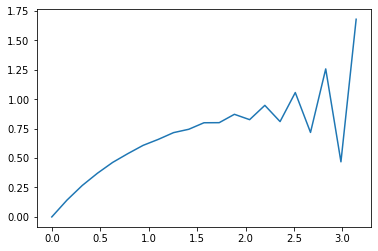

In [29]:
# Problem domain
omega = [0,np.pi]

alpha = lambda x : 0.01 * np.ones(len(x))
beta = lambda x :  1. * np.ones(len(x))
gamma = lambda x : 1 * np.ones(len(x))
rhs = lambda x :   1 * np.ones(len(x))

# Grid
N=20
h = (omega[1]-omega[0])/N
x = np.linspace(omega[0],omega[1],N+1)

# FD system
A, F = FD1Dalt(omega,N,alpha,beta,gamma,rhs)

# solve
Uh = sp.linalg.spsolve(A,F)

# insert boundary conditions
#Uh = np.insert(Uh,[0, N-1], [0., 0.])

# plot solution
plt.plot(x,Uh)

Repeat exercise with larger system including boundary conditions

Compute experimental order of convergence (EOC) using knowledge that 

$|| U-U_h ||_\infty \approx C h^k$

with $C$ independent of $h$. Hence,

$\frac{|| U-U_{h_1} ||_\infty}{|| U-U_{h_2} ||_\infty}\approx\large(\frac{h_1}{h_2}\large)^k$,

and then,

$k\approx\frac{\log || U-U_{h_1} ||_\infty-\log|| U-U_{h_2} ||_\infty}{\log h_1 - \log h_2}$.

Notice that to estimate the EOC you need to run at least two experiments, for instance with $h_1=h$, $h_2=h/2$.

In [ ]:
# Problem domain
omega = [0,np.pi]

alpha = lambda x : 1. * np.ones(len(x))
beta = lambda x :  0. * np.ones(len(x))
gamma = lambda x : 0. * np.ones(len(x))
rhs =   lambda x : np.sin(x)
sol =   lambda x : np.sin(x)

# Fix number of experiments
no_experiments = 12

# initialise with first experiment

# evaluate system for given N
N = 5
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)
# Solve
U1 = sp.linalg.spsolve(A,F)

for i in range(no_experiments-1):
  # evaluate system for given N

#exercise or copy professor solution


  # Solve
 
  # Compute error 

  # Update



What if the exact solution is not known? Then we can still estiate the EOC but three experiments. Indeed, letting $h_2=\theta h_1$, we have

$|| U_{h_2}-U_{h_1} ||_\infty\le || U-U_{h_1} ||_\infty + || U-U_{h_2} ||_\infty\approx C h_1^k+C h_2^k \approx C (1+\theta^k) h_1^k$

Now, given also $h_3 = \theta h_2$, we have similarly

$|| U_{h_3}-U_{h_2} ||_\infty \approx C (1+\theta^k) h_2^k=C (1+\theta^k)\theta^k h_1^k$

hence,

$\frac{|| U_{h_2}-U_{h_1} ||_\infty}{|| U_{h_3}-U_{h_2} ||_\infty}\approx \frac{C (1+\theta^k) h_1^k}{C (1+\theta^k)\theta^k h_1^k}=\theta^{-k}$

from which $k$ can be estimated as before by passing to the logs.

**Exercise:** try this out for the problem with $f=1$.

# Finite Difference in 2D

1. Finite Difference solver for the 2D Poisson problem:

$-\Delta u=f \quad \in \Omega=(a,b)^2$

$u|_{\partial\Omega}=0$

Function computing the 1D FD algebric system

In [ ]:
def FD2D(omega,N,rhs):
  # FD system matrix and rhs in omega^2 for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format
  # with Nx = Ny = N

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)
  y = x

  # Compute rhs
  
  # compute system matrix

  # Implement boundary conditions


  return

Define FD problem and solve

In [ ]:
omega = [0,np.pi,0,np.pi]
N = 100
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
exact = lambda x, y : np.sin(x) * np.sin(y)

# call function computing FD system

# solve

# plot solution

# Prepare data for plotting 

# Plot the solution
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()






**Exercise:** Compute error and EOC 

**Exercise:** Generalise to more general elliptic problems (PDE and boundary conditions)